In [1]:
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import os
os.chdir('/fast/work/groups/ag_kircher/ReMM/MA_Lusi/Snakemake')


sys.path.append('utils')
#import fun 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
import matplotlib.font_manager
plt.rcParams["font.family"] = "Times New Roman"

#mpl.rcParams['font.family'] = ['serif']
#mpl.rcParams['font.serif'] = ['Times New Roman']

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)

from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

### Prepare the data

In [3]:
#file = '/fast/work/groups/ag_kircher/ReMM/ReMM/data/variants/RegulatoryMendelianMutations/GRCh37/SNVs.all.20160109.vcf.gz'
#pp = pd.read_csv(file, sep = '\t',skiprows = 8,header = None)
#pos = pp[(pp[3].str.len()==1)&(pp[4].str.len()==1)]
#pos[3]=pos[0].astype(str)+'-'+pos[1].astype(str)


file = 'output/predictions/lifted/new/hg38.predictions.lifted.txt'
df = pd.read_csv(file,sep='\t',header = None)
file = 'output/predictions/lifted/new/SNVs.lifted.remm.txt'
remm = pd.read_csv(file,sep='\t',header = None)

remm[3]= remm[0].astype(str)+'-'+(remm[1]).astype(str)
df[3]= df[0].astype(str)+'-'+(df[1]).astype(str)
df['ID']=list(range(len(df)))

remm = remm.set_index([3])
df = df.set_index([3])

ff = remm.join(df,lsuffix='_remm',rsuffix='_ps',how='inner')
f = ff.drop_duplicates('ID')
#ind = f[f.index.isin(pos[3])].index
#f['label']=0
#f.loc[ind,'label']=1
#f['label'].value_counts()
f['label']=f['2_ps'].str.split(':',expand=True)[3].astype(int)
f['prob_ps'] = f['2_ps'].str.split(':',expand = True)[2].astype(float)
f['lab_ps'] = f['prob_ps'].astype(float).apply(lambda x: 0 if x < 0.5 else 1)
f['prob_ps'] = f['prob_ps'].round(3)
f['prob_remm'] = f['2_remm']#.str.split(':',expand = True)[2].astype(float)
f['lab_remm'] = f['prob_remm'].astype(float).apply(lambda x: 0 if x < 0.5 else 1)


f.head()

,0_remm,1_remm,2_remm,0_ps,1_ps,2_ps,ID,label,prob_ps,lab_ps,prob_remm,lab_remm
3,,,,,,,,,,,,
chr1-100000176,chr1,100000176,0.202,chr1,100000176,chr1:99534620:0.038656:0,494817,0,0.039,0,0.202,0
chr1-10000026,chr1,10000026,0.059,chr1,10000026,chr1:9939968:0.000333333:0,55310,0,0.000,0,0.059,0
chr1-100000432,chr1,100000432,0.033,chr1,100000432,chr1:99534876:0.0215794:0,494818,0,0.022,0,0.033,0
chr1-10000069,chr1,10000069,0.062,chr1,10000069,chr1:9940011:0.000333333:0,55311,0,0.000,0,0.062,0
chr1-100000837,chr1,100000837,0.020,chr1,100000837,chr1:99535281:0:0,494819,0,0.000,0,0.020,0


In [5]:
file = '/fast/work/groups/ag_kircher/ReMM/ReMM/data/variants/RegulatoryMendelianMutations/GRCh37/SNVs.all.20160109.vcf.gz'
pp = pd.read_csv(file, sep = '\t',skiprows = 8,header = None)
pos = pp[(pp[3].str.len()==1)&(pp[4].str.len()==1)]
pos[3]=pos[0].astype(str)+'-'+pos[1].astype(str)


pos[8]=pos[7].str.split(';',expand = True)[4].str.split('=',expand = True)[1]


pos = pos.set_index([3])
f = f.join(pos[8])
f = f.drop_duplicates('ID')



f[8] = f[8].str.replace('RNP_RNAcomponent','RNA')
f[8] = f[8].str.replace('UTR','\' UTR')
f[8] = f[8].str.replace('microRNAgene','microRNAgene')

a = f[8].value_counts()

<ipython-input-5-6dcd3aa2927f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos[3]=pos[0].astype(str)+'-'+pos[1].astype(str)
<ipython-input-5-6dcd3aa2927f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos[8]=pos[7].str.split(';',expand = True)[4].str.split('=',expand = True)[1]


5UTR                134
promoter            130
RNP_RNAcomponent     60
3UTR                 38
enhancer             37
microRNAgene          5
ICR                   3
Name: 8, dtype: int64

In [31]:
p = 'parSMURF'
r = 'ReMM'
#p= 'GRCh38'
#r = 'GRCh37'

### Plot number of variants across groups

<ipython-input-11-7bbb928f85b3>:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "di" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figures/variant_groups.png',di=30,bbox_inches='tight')


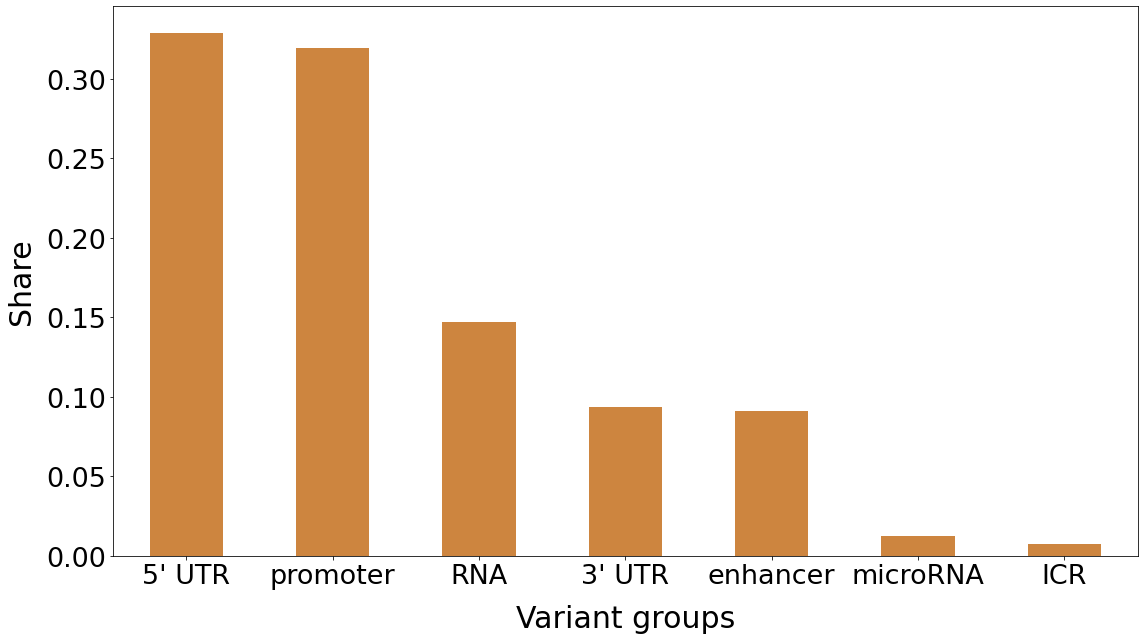

In [11]:

x = 3
a = f[8].value_counts(normalize = True)
index = a.index
ax = a.plot.bar(rot=0,figsize=(16,9), color={"peru"})
ax.set_xlabel('Variant groups', fontsize = 10*x,labelpad=15)
ax.set_ylabel('Share',fontsize = 10*x,labelpad=10)
ax.tick_params(axis='both',  labelsize=9*x)
plt.tight_layout()
#plt.savefig('figures/variant_groups.png',di=30,bbox_inches='tight')



### Plot false negatives across groups

In [17]:
ff = f[f['label']==1]

ff[8] = ff[8].str.replace('RNP_RNAcomponent','RNA')
ff[8] = ff[8].str.replace('UTR','\' UTR')
a = pd.crosstab(ff['lab_remm'],ff[8]).T
a['Sum']=a.sum(axis = 1)

a[3]=a[0]/a['Sum']
a[4]=a[1]/a['Sum']


b = pd.crosstab(ff['lab_ps'],ff[8]).T
b['Sum']=b.sum(axis = 1)

b[3]=b[0]/b['Sum']
b[4]=b[1]/b['Sum']


d = pd.DataFrame()

d[[0,1]]=a[[0,1]]
d[[2,3]]=b[[0,1]]

aa = ['ReMM','ReMM','parSMURF','parSMURF']
bb = ['False','Correct','False','Correct']
index = pd.MultiIndex.from_tuples(list(zip(aa,bb)), names=["", ""])
d = d.T
d.index = index

d['Total']=d.sum(axis = 1)
d['Total'] = d['Total'].astype(int)


#d.T.to_latex('figures/groups.tex')

<ipython-input-17-d13eb199d432>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ff[8] = ff[8].str.replace('RNP_RNAcomponent','RNA')
<ipython-input-17-d13eb199d432>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ff[8] = ff[8].str.replace('UTR','\' UTR')


<ipython-input-205-690d031a6c3f>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "di" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figures/variant_groups.png',di=30,bbox_inches='tight')


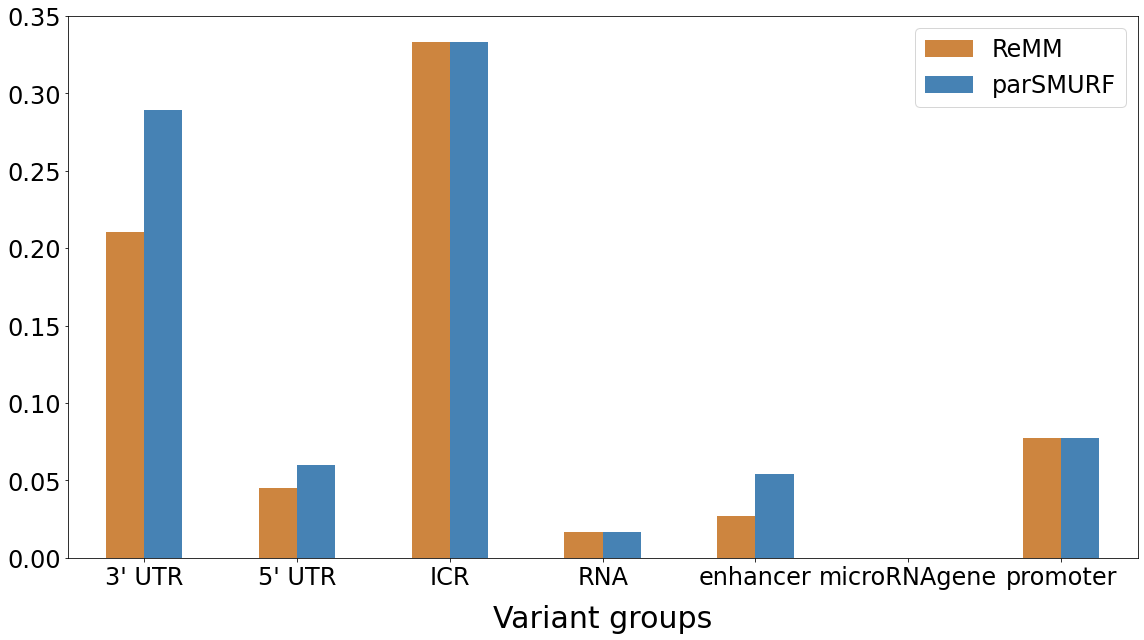

In [205]:
x = 3

ReMM = a[3]
parSMURF = b[3]
index = b.index
df = pd.DataFrame({'ReMM': ReMM,
                    'parSMURF': parSMURF}, index=index)
ax = df.plot.bar(rot=0,figsize=(16,9), color={"ReMM": "peru", "parSMURF": "steelblue"})
ax.set_xlabel('Variant groups', fontsize = 10*x,labelpad=15)
ax.tick_params(axis='both',  labelsize=8*x)
plt.legend(fontsize = 8*x)
plt.tight_layout()

#plt.savefig('figures/variant_groups.png',di=30,bbox_inches='tight')



In [61]:
pd.crosstab(ff['lab_ps'],ff[8],normalize = True)

8,3UTR,5UTR,ICR,RNP_RNAcomponent,enhancer,microRNAgene,promoter
lab_ps,,,,,,,
0,0.027094,0.019704,0.002463,0.002463,0.004926,0.000000,0.024631
1,0.066502,0.310345,0.004926,0.145320,0.086207,0.012315,0.293103


### Confusion matrices

In [9]:
p_re = f[f.lab_remm==1]
p_ps = f[f.lab_ps==1]

p_re['prob_remm'].min()
p_ps['prob_ps'].min()


corr= pd.DataFrame()
corr['remm'] = f['2_remm']
corr['ps']= f['2_ps'].str.split(':',expand = True)[2]
corr[['remm','ps']].astype(float).corr()

In [13]:
remm_lab = corr['remm'].apply(lambda x: 0 if x < 0.5 else 1)
ps_lab = corr['ps'].astype(float).apply(lambda x: 0 if x < 0.5 else 1)


cm_remm = confusion_matrix(f['label'], remm_lab)
cm_ps = confusion_matrix(f['label'], ps_lab)
cm_ps

array([[13786489,    87241],
       [      33,      373]])

In [45]:

cm_remm_norm = confusion_matrix(f['label'], remm_lab,normalize='true')
cm_ps_norm = confusion_matrix(f['label'], ps_lab,normalize='true')

cm_ps

array([[13786489,    87241],
       [      33,      373]])

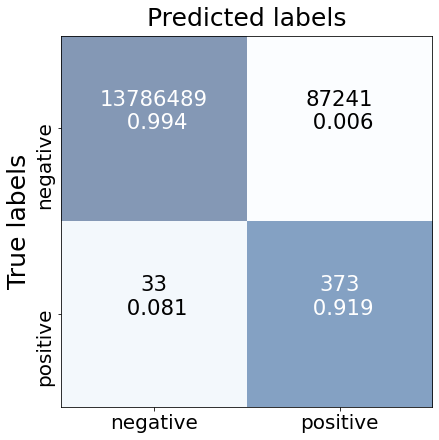

In [137]:
import numpy as np
from sklearn.metrics import confusion_matrix
plt.rcParams['font.family'] = "Times New Roman"
import matplotlib.pyplot as plt
import numpy as np
import itertools


def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize = False):
   
    
    plt.rcParams['font.family'] = "Times New Roman"

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
        #cmap = None

    cm_a = cm  
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax  =plt.subplots(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap,alpha=0.5)
    #plt.title(title)
    #plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=0,size = 15)
        plt.yticks(tick_marks, target_names,size = 15)

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    x = 2.5

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
  #  thresh = cm_norm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, str(cm_a[i, j])+'\n '+str("{:0.3f}".format(cm_norm[i, j])),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",size = 8.5*x)

    plt.tight_layout()
    plt.ylabel('True labels',fontsize = 10*x)
   # plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0*.4f}'.format(accuracy, misclass))
    plt.xlabel('Predicted labels', fontsize = 10*x,labelpad = 10)
    ax.xaxis.set_label_position('top')
    plt.yticks(rotation='vertical',fontsize = 8*x)
    plt.xticks(fontsize = 8*x)

    #plt.set_label_position('top')    
    plt.savefig('figures/cm_ps.png',bbox_inches = "tight")
    plt.show()

plt.rc('font', family='serif', size=18)
plot_confusion_matrix(cm_ps, target_names =['negative','positive'],normalize=True)


### Performance measures 

In [2]:
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
import sklearn.metrics as sm
from matplotlib import pyplot
import pandas as pd
def evaluate(lab,prob):
    temp = pd.DataFrame()
    temp[1]=prob
    temp[0]=1-prob
    pred = temp.idxmax(axis = 1)
    precision, recall, thresholds = sm.precision_recall_curve(lab, prob)

    p=precision.mean()
    r=recall.mean()
    a=sm.accuracy_score(lab,pred)
    f=sm.f1_score(lab, pred, average='binary')
    au=sm.roc_auc_score(lab,prob)
    l = list(zip(['Accuracy','Precision','Recall','F-score'],[a,p,r,f]))
    return l


In [65]:
df = pd.read_csv('output/predictions/hg38/SNVs.hg38.cv.predictions.txt',header = None, sep = '\t')

In [70]:

file = 'output/features/annotated/hg38/SNVs.hg38.labels.txt'
labels = pd.read_csv(file,sep='\t',header = None, usecols = [0])[0]

predictions = df[0]

In [71]:
labels.value_counts()

0    13896960
1        5680
Name: 0, dtype: int64

In [72]:
evaluate(labels,predictions)

[('Accuracy', 0.9976791458312954),
 ('Precision', 0.05772373941398767),
 ('Recall', 0.9869334908573033),
 ('F-score', 0.2586618876941458)]

In [73]:
average_precision_score(labels, predictions)

0.7237874709395005

In [76]:
ps[:406]

360

In [56]:
ps = pd.Series([0]*len(predictions))
ps

0           0
1           0
2           0
3           0
4           0
           ..
13902635    0
13902636    0
13902637    0
13902638    0
13902639    0
Length: 13902640, dtype: int64

In [57]:
ps = pd.Series([0]*len(predictions))
ind = predictions[predictions>=0.5].index

In [58]:
ps[ind]=1
ps.sum()

37844

In [59]:
ind = labels[labels==1].index

ps[ind].sum()

5629

In [53]:
a = evaluate(f['label'],f['prob_remm'])
b =evaluate(f['label'],f['prob_ps'])
a = pd.DataFrame(a)
b = pd.DataFrame(b)
a[2]=b[1]
a = a.set_index(0,drop = True)
a.columns = ['ReMM','parSMURF']
a.index.name = ''
#a.to_latex('figures/measures.tex', index = True,column_format = 'lll')
a

### AUROC and AUPRC

In [22]:
from glob import glob

In [23]:
file = 'output/features/annotated/hg38/SNVs.hg38.labels.txt'
labels = pd.read_csv(file,sep='\t',header = None, usecols = [0])[0]
li = glob('output/predictions/old_hg38/*.txt*')

In [ ]:
f.head()


#### Read prediction file from repeated cross-validation

In [24]:
all_ = pd.DataFrame()
all_index = np.linspace(0,1,10000).round(4)
for i in range(len(li)):
    temp = pd.read_csv(li[i], sep = '\t', header = None)[0]
    precision, recall, _ = precision_recall_curve(labels, temp)

    df = pd.DataFrame(precision,recall).reset_index()
    df['t'] = pd.Series(0).append(pd.Series(_)).reset_index()[0].round(4)
    df.columns = ['precision'+'_'+str(i),'recall'+'_'+str(i),'t']
    df = df.drop_duplicates(subset= ['t'],keep = 'first')
    df = df.set_index(['t'], drop = True)
    all_ = pd.concat([all_,df], axis = 1)

precision_val = all_.loc[:,all_.columns.str.contains('precision')].mean(axis = 1)
recall_val = all_.loc[:,all_.columns.str.contains('recall')].mean(axis = 1)



#### Plot PRC of  repeated cross-validation

<ipython-input-133-3b4328ca827a>:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "di" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figures/prc_validation_30.png',di=30,bbox_inches='tight')


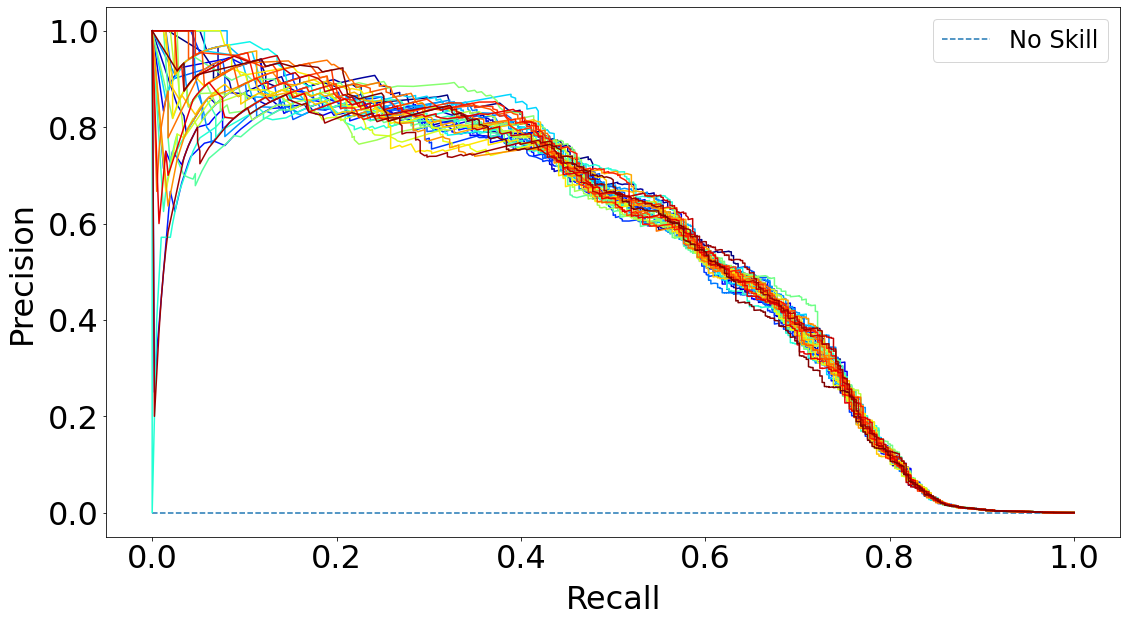

In [133]:


fig, ax = plt.subplots(figsize=(16,9))  

x = 4
y = f['label']
no_skill = len(y[y==1]) / len(y)

plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
all_ = all_.fillna(method = 'ffill')
colors = plt.cm.jet(np.linspace(0,1,int(all_.shape[1]/2)))


for i in list(range(len(li))):
    df = all_.loc[:,all_.columns.str.contains(str(i))]
    plt.plot(df.iloc[:,0], df.iloc[:,1], color=colors[i])
    
ax.tick_params(axis='both',  labelsize=8*x)
ax.set_xlabel('Recall', fontsize = 8*x,labelpad=10)
ax.set_ylabel('Precision',fontsize = 8*x,labelpad=10)

plt.legend(fontsize = 6*x)
plt.tight_layout()



plt.savefig('figures/prc_validation_30.png',di=30,bbox_inches='tight')


#### Plot  AUPRC 

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
<ipython-input-12-f53682c1987b>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "di" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figures/prc.png',di=30,bbox_inches='tight')


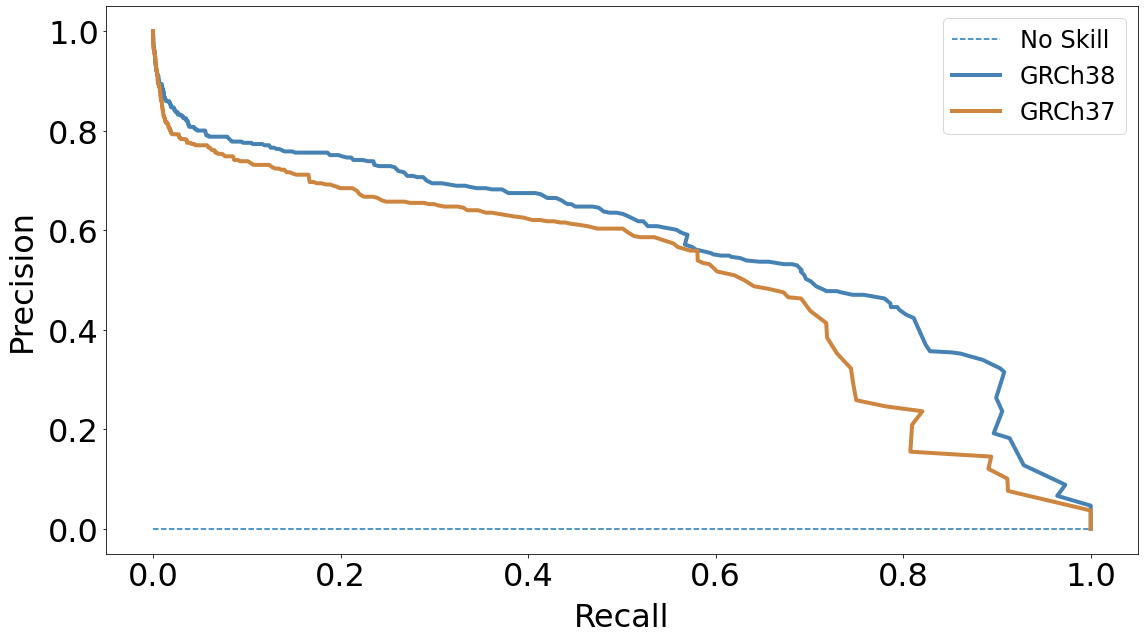

In [12]:
fig, ax = plt.subplots(figsize=(16,9))  

x = 4
y = f['label']
no_skill = len(y[y==1]) / len(y)

plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
precision_ps, recall_ps, _ps = precision_recall_curve(f['label'],f['prob_ps'])
plt.plot(precision_ps, recall_ps, label = 'GRCh38',color='steelblue',linewidth = 4)

prec_re, rec_re, _re = precision_recall_curve(f['label'],f['2_remm'])
plt.plot(prec_re, rec_re,label='GRCh37',color='peru',linewidth = 4)

ax.tick_params(axis='both',  labelsize=8*x)
ax.set_xlabel('Recall', fontsize = 8*x,labelpad=10)
ax.set_ylabel('Precision',fontsize = 8*x,labelpad=10)

plt.legend(fontsize = 6*x)
plt.tight_layout()

plt.savefig('figures/prc.png',di=30,bbox_inches='tight')


#### Plot AUROC

<ipython-input-28-0c86418f6002>:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "di" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figures/roc.png',di=30,bbox_inches='tight')


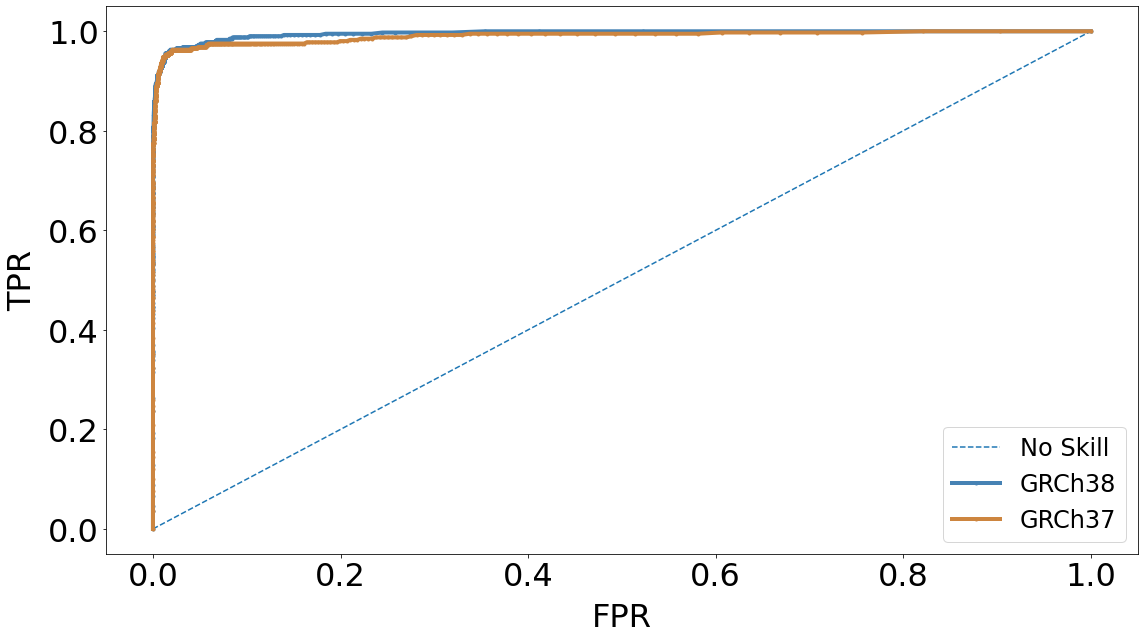

In [28]:
p = 'parSMURF'
r = 'ReMM'
p= 'GRCh38'
r = 'GRCh37'
fig, ax = plt.subplots(figsize=(16,9))  

x = 4
y = f['label']
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

fpr, tpr, _ = roc_curve(f['label'], f['prob_ps'])
plt.plot(fpr, tpr, marker='.', label=p,color='steelblue',linewidth = 4)

fpr1, tpr1, _1 = roc_curve(f['label'], f['prob_remm'])
plt.plot(fpr1, tpr1, marker='.', label=r,color='peru',linewidth = 4)

ax.tick_params(axis='both',  labelsize=8*x)
ax.set_xlabel('FPR', fontsize = 8*x,labelpad=10)
ax.set_ylabel('TPR',fontsize = 8*x,labelpad=10)

plt.legend(fontsize = 6*x)
plt.tight_layout()

plt.savefig('figures/roc.png',di=30,bbox_inches='tight')


####  Plot PRC of  repeated cross-validation

<ipython-input-25-ea059e7246a4>:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "di" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figures/prc_validation.png',di=30,bbox_inches='tight')


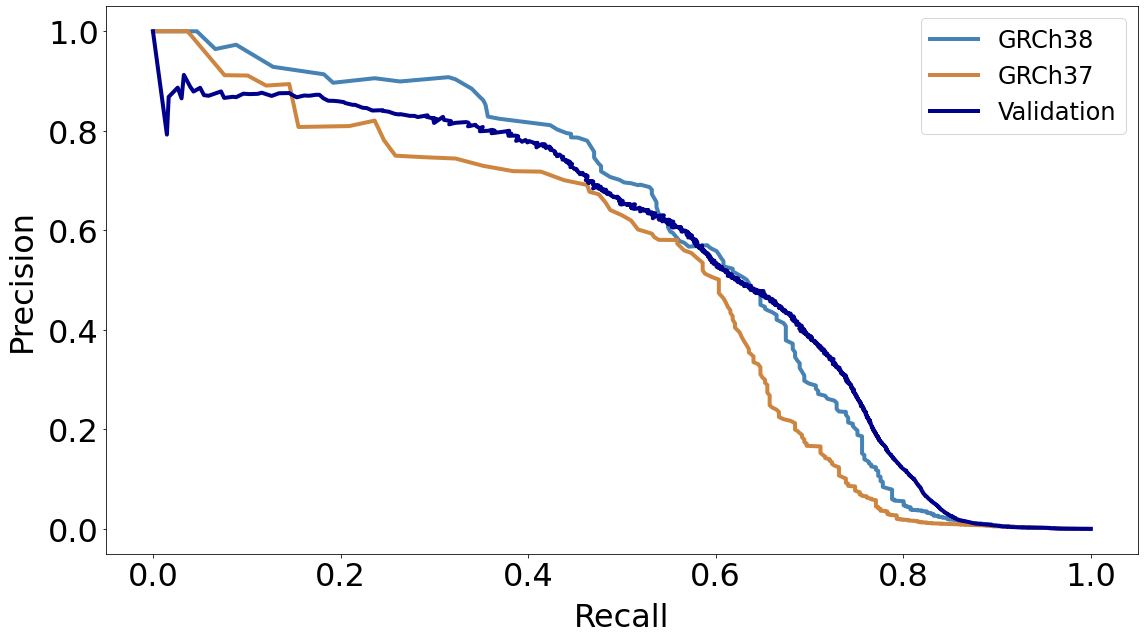

In [25]:
fig, ax = plt.subplots(figsize=(16,9))  

x = 4
y = f['label']
no_skill = len(y[y==1]) / len(y)

precision, recall, _ = precision_recall_curve(y, f['prob_ps'])
plt.plot(recall, precision, label='GRCh38',color='steelblue',linewidth = 4)

precision1, recall1, _1 = precision_recall_curve(y, f['2_remm'])
plt.plot(recall1, precision1, label='GRCh37',color='peru',linewidth = 4)


precision = all_.loc[:,all_.columns.str.contains('precision')].mean(axis = 1)
recall = all_.loc[:,all_.columns.str.contains('recall')].mean(axis = 1)

plt.plot(precision, recall, label = 'Validation',color='darkblue',linewidth = 4)
ax.tick_params(axis='both',  labelsize=8*x)
ax.tick_params(axis='both',  labelsize=8*x)
ax.set_xlabel('Recall', fontsize = 8*x,labelpad=10)
ax.set_ylabel('Precision',fontsize = 8*x,labelpad=10)

plt.legend(fontsize = 6*x)
plt.tight_layout()


plt.savefig('figures/prc_validation.png',di=30,bbox_inches='tight')







### Score distribution

In [ ]:
c = 0.24999999999
f['prob_ps'] = f['prob_ps'].astype(float)
re = f[f['prob_remm']>=c]['prob_remm']
ps =f[f['prob_ps']>=c]['prob_ps']
print(re.mean())
print(ps.mean())

re_ = f[f['prob_remm']<c]['prob_remm']
ps_ =f[f['prob_ps']<c]['prob_ps']

In [ ]:
c = 0.25
re = f[f['prob_remm']>=c]['prob_remm']
ps =f[f['prob_ps']>=c]['prob_ps']
print(re.mean())
print(ps.mean())

#### Boxplots

0_0.25_all


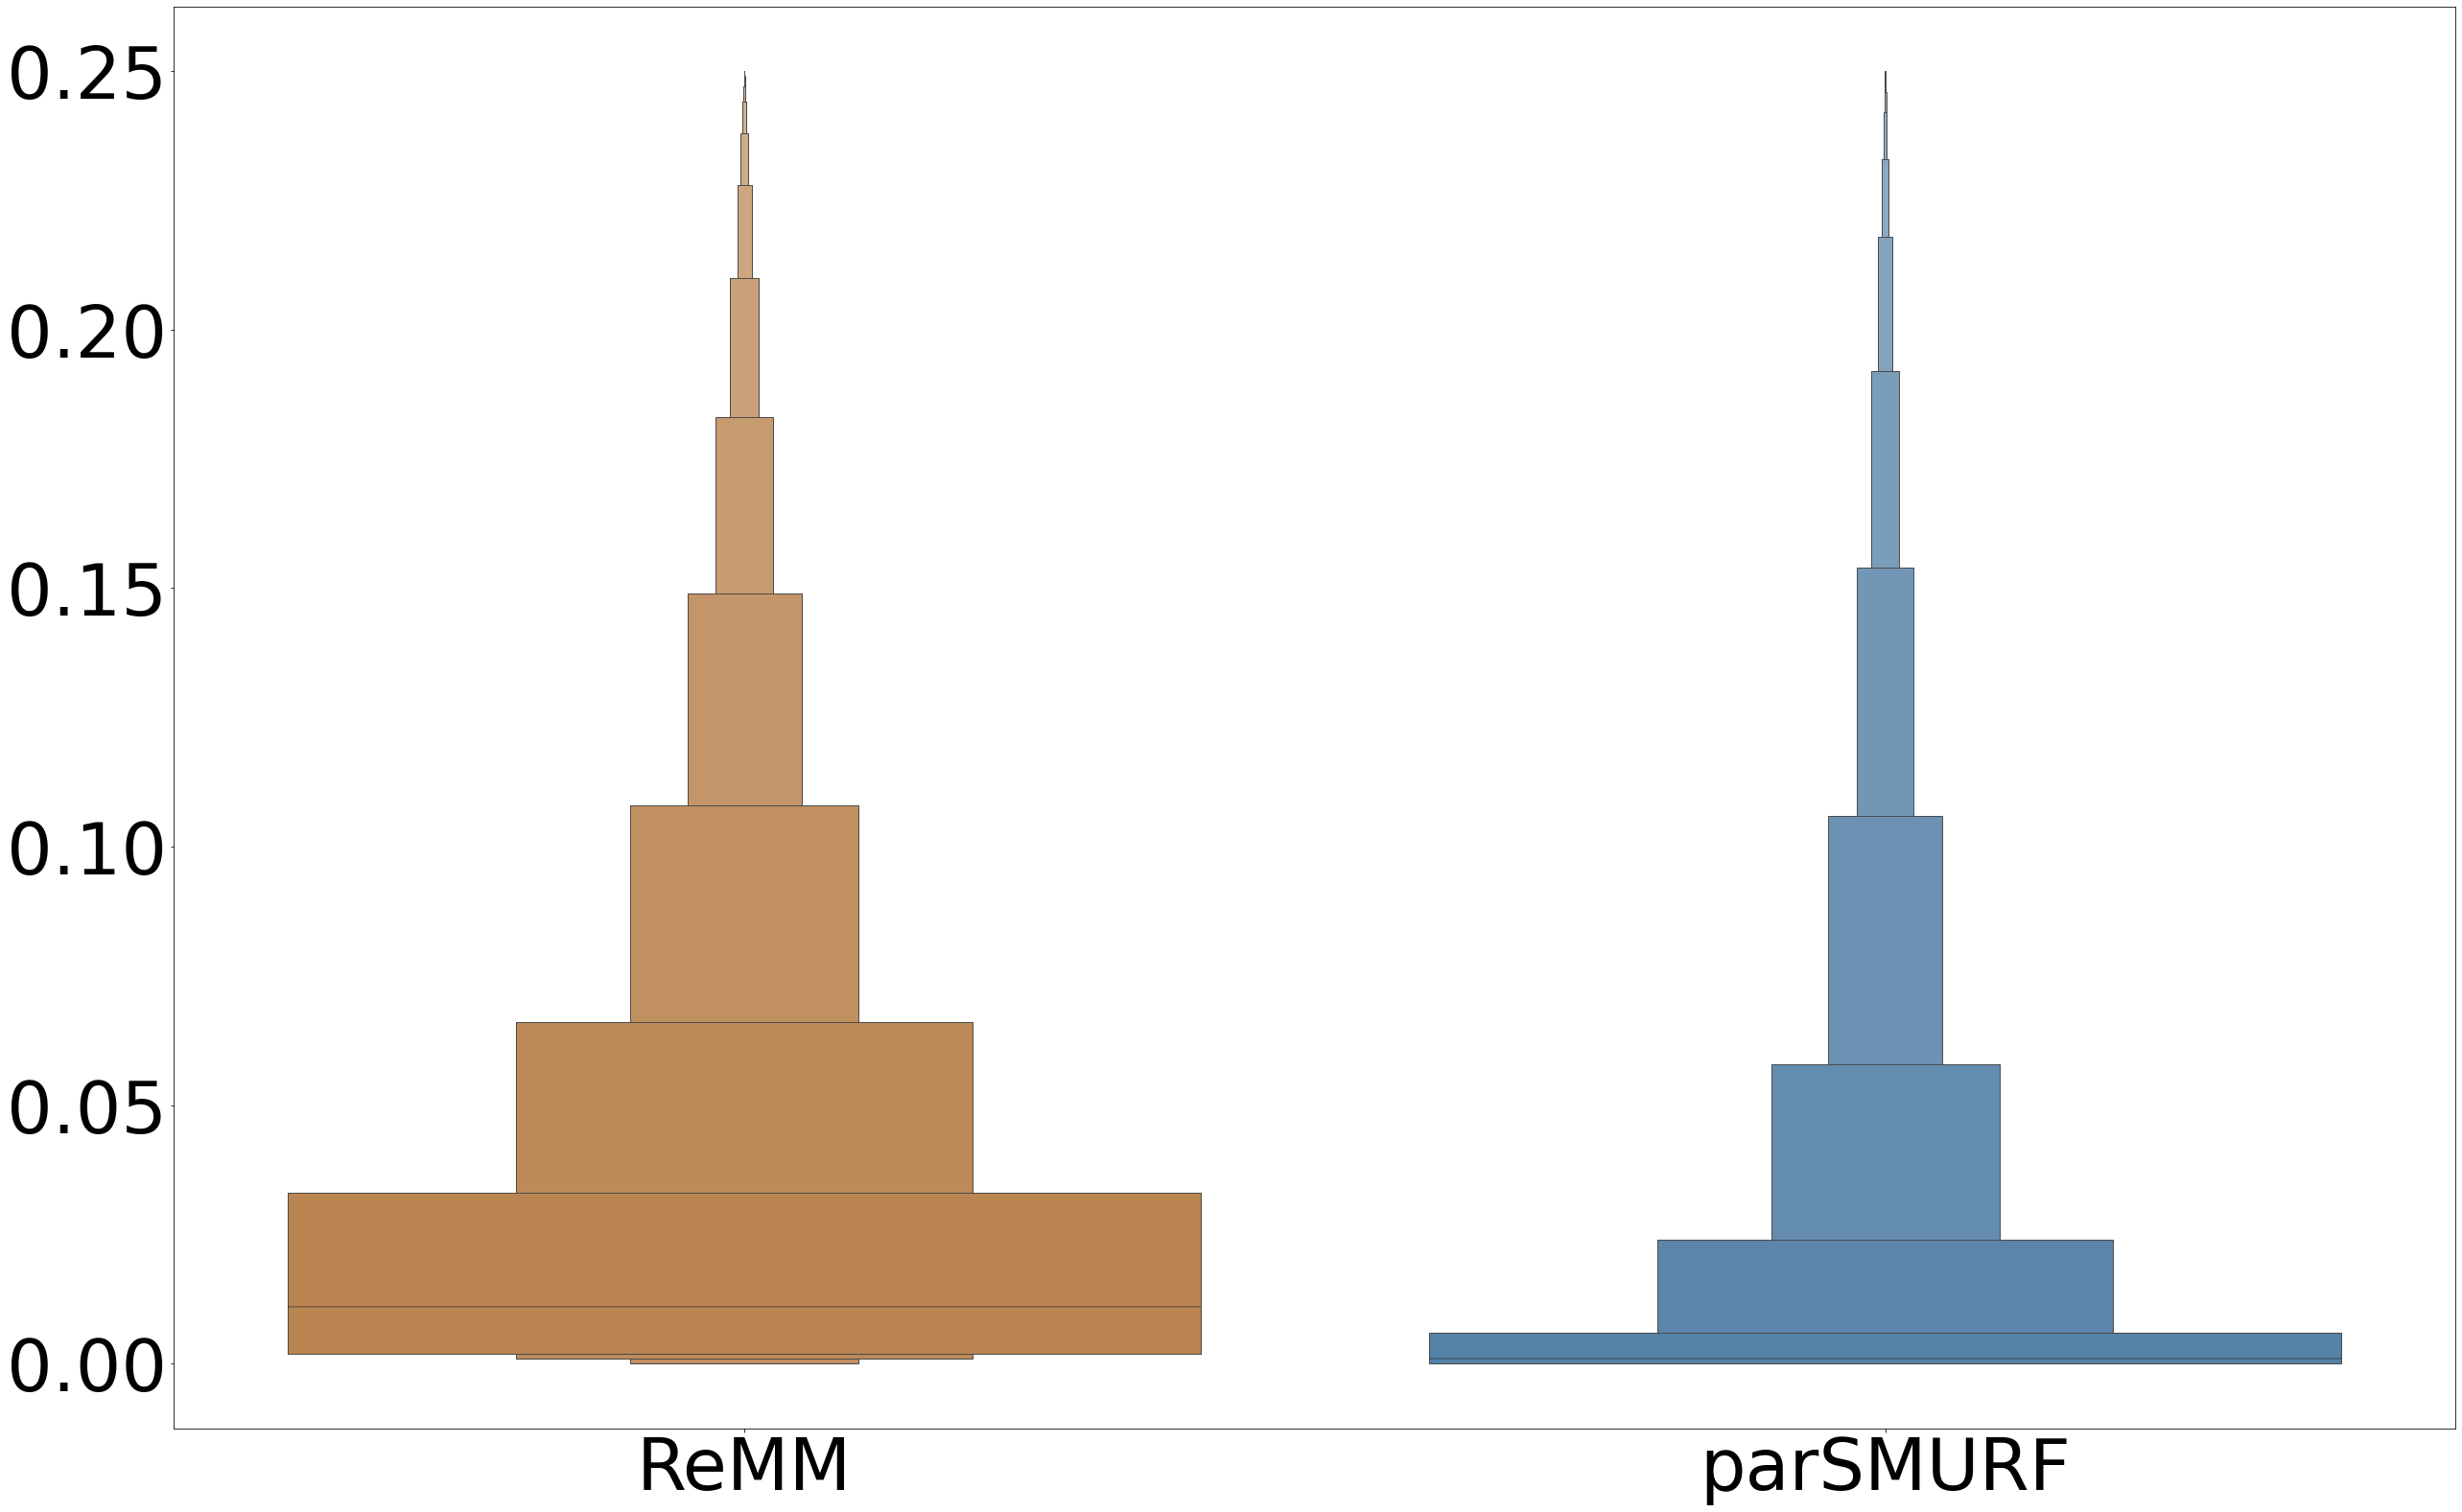

0.25_1_all


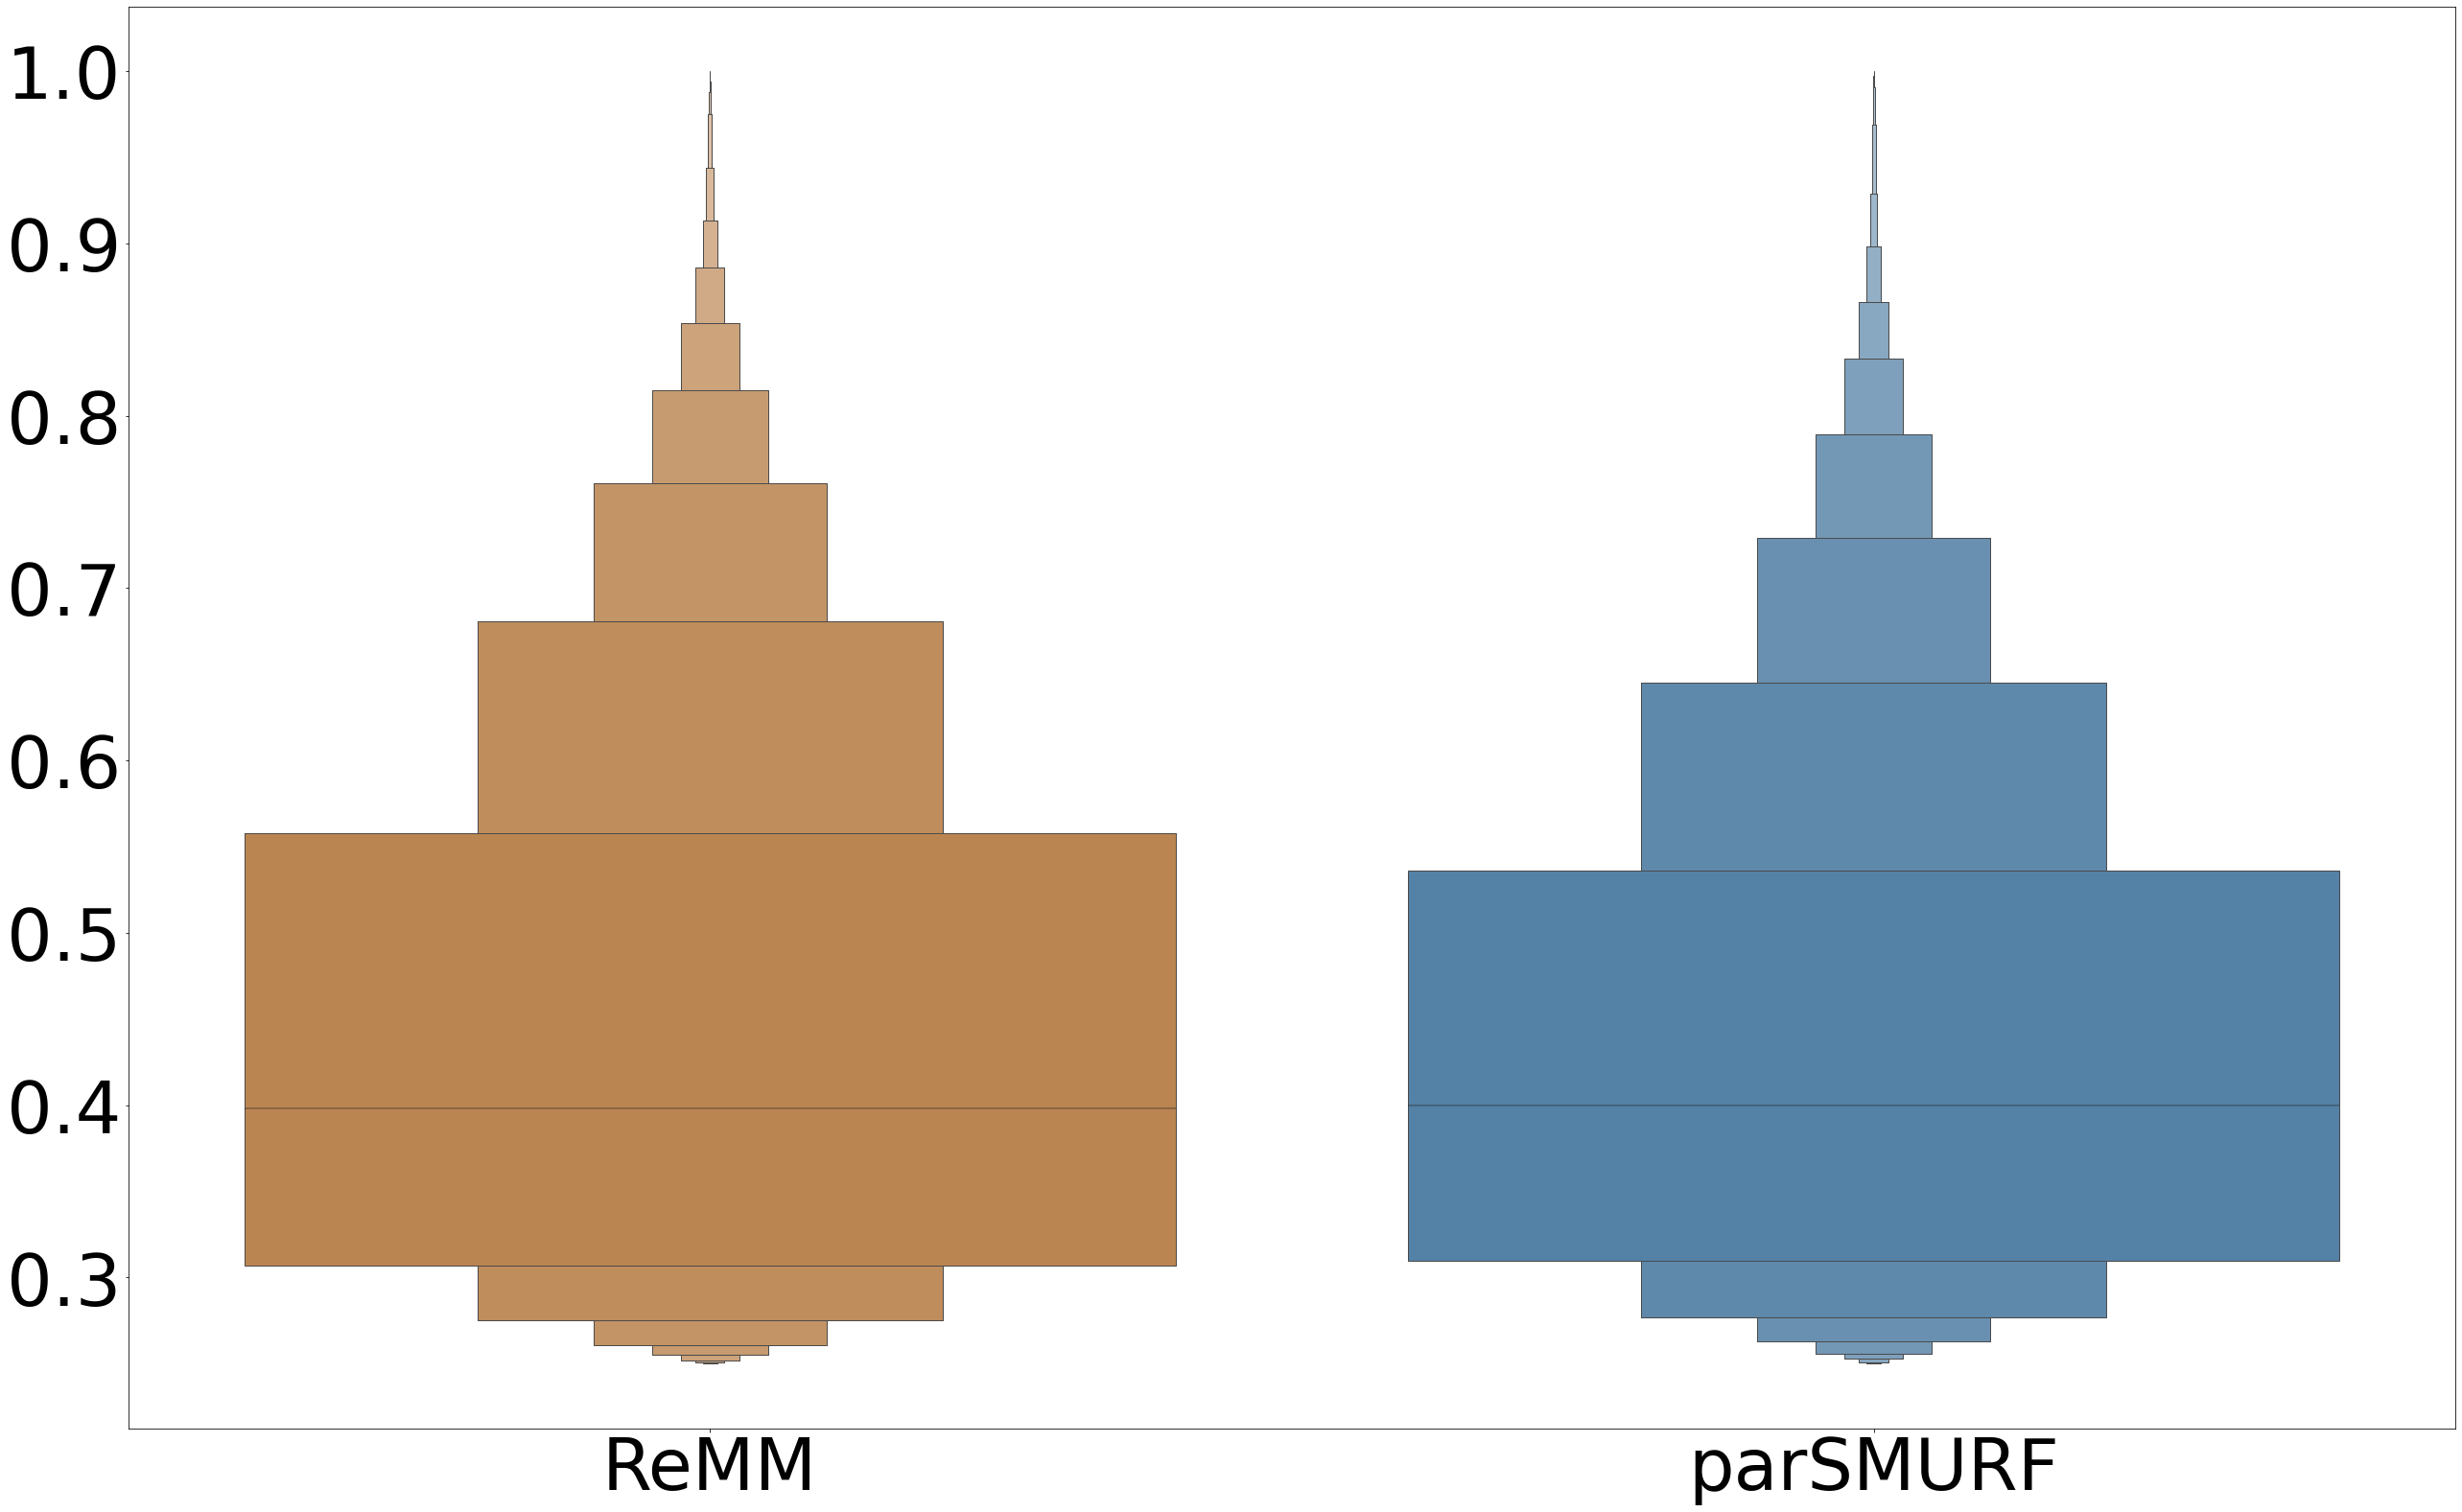

0_1_all


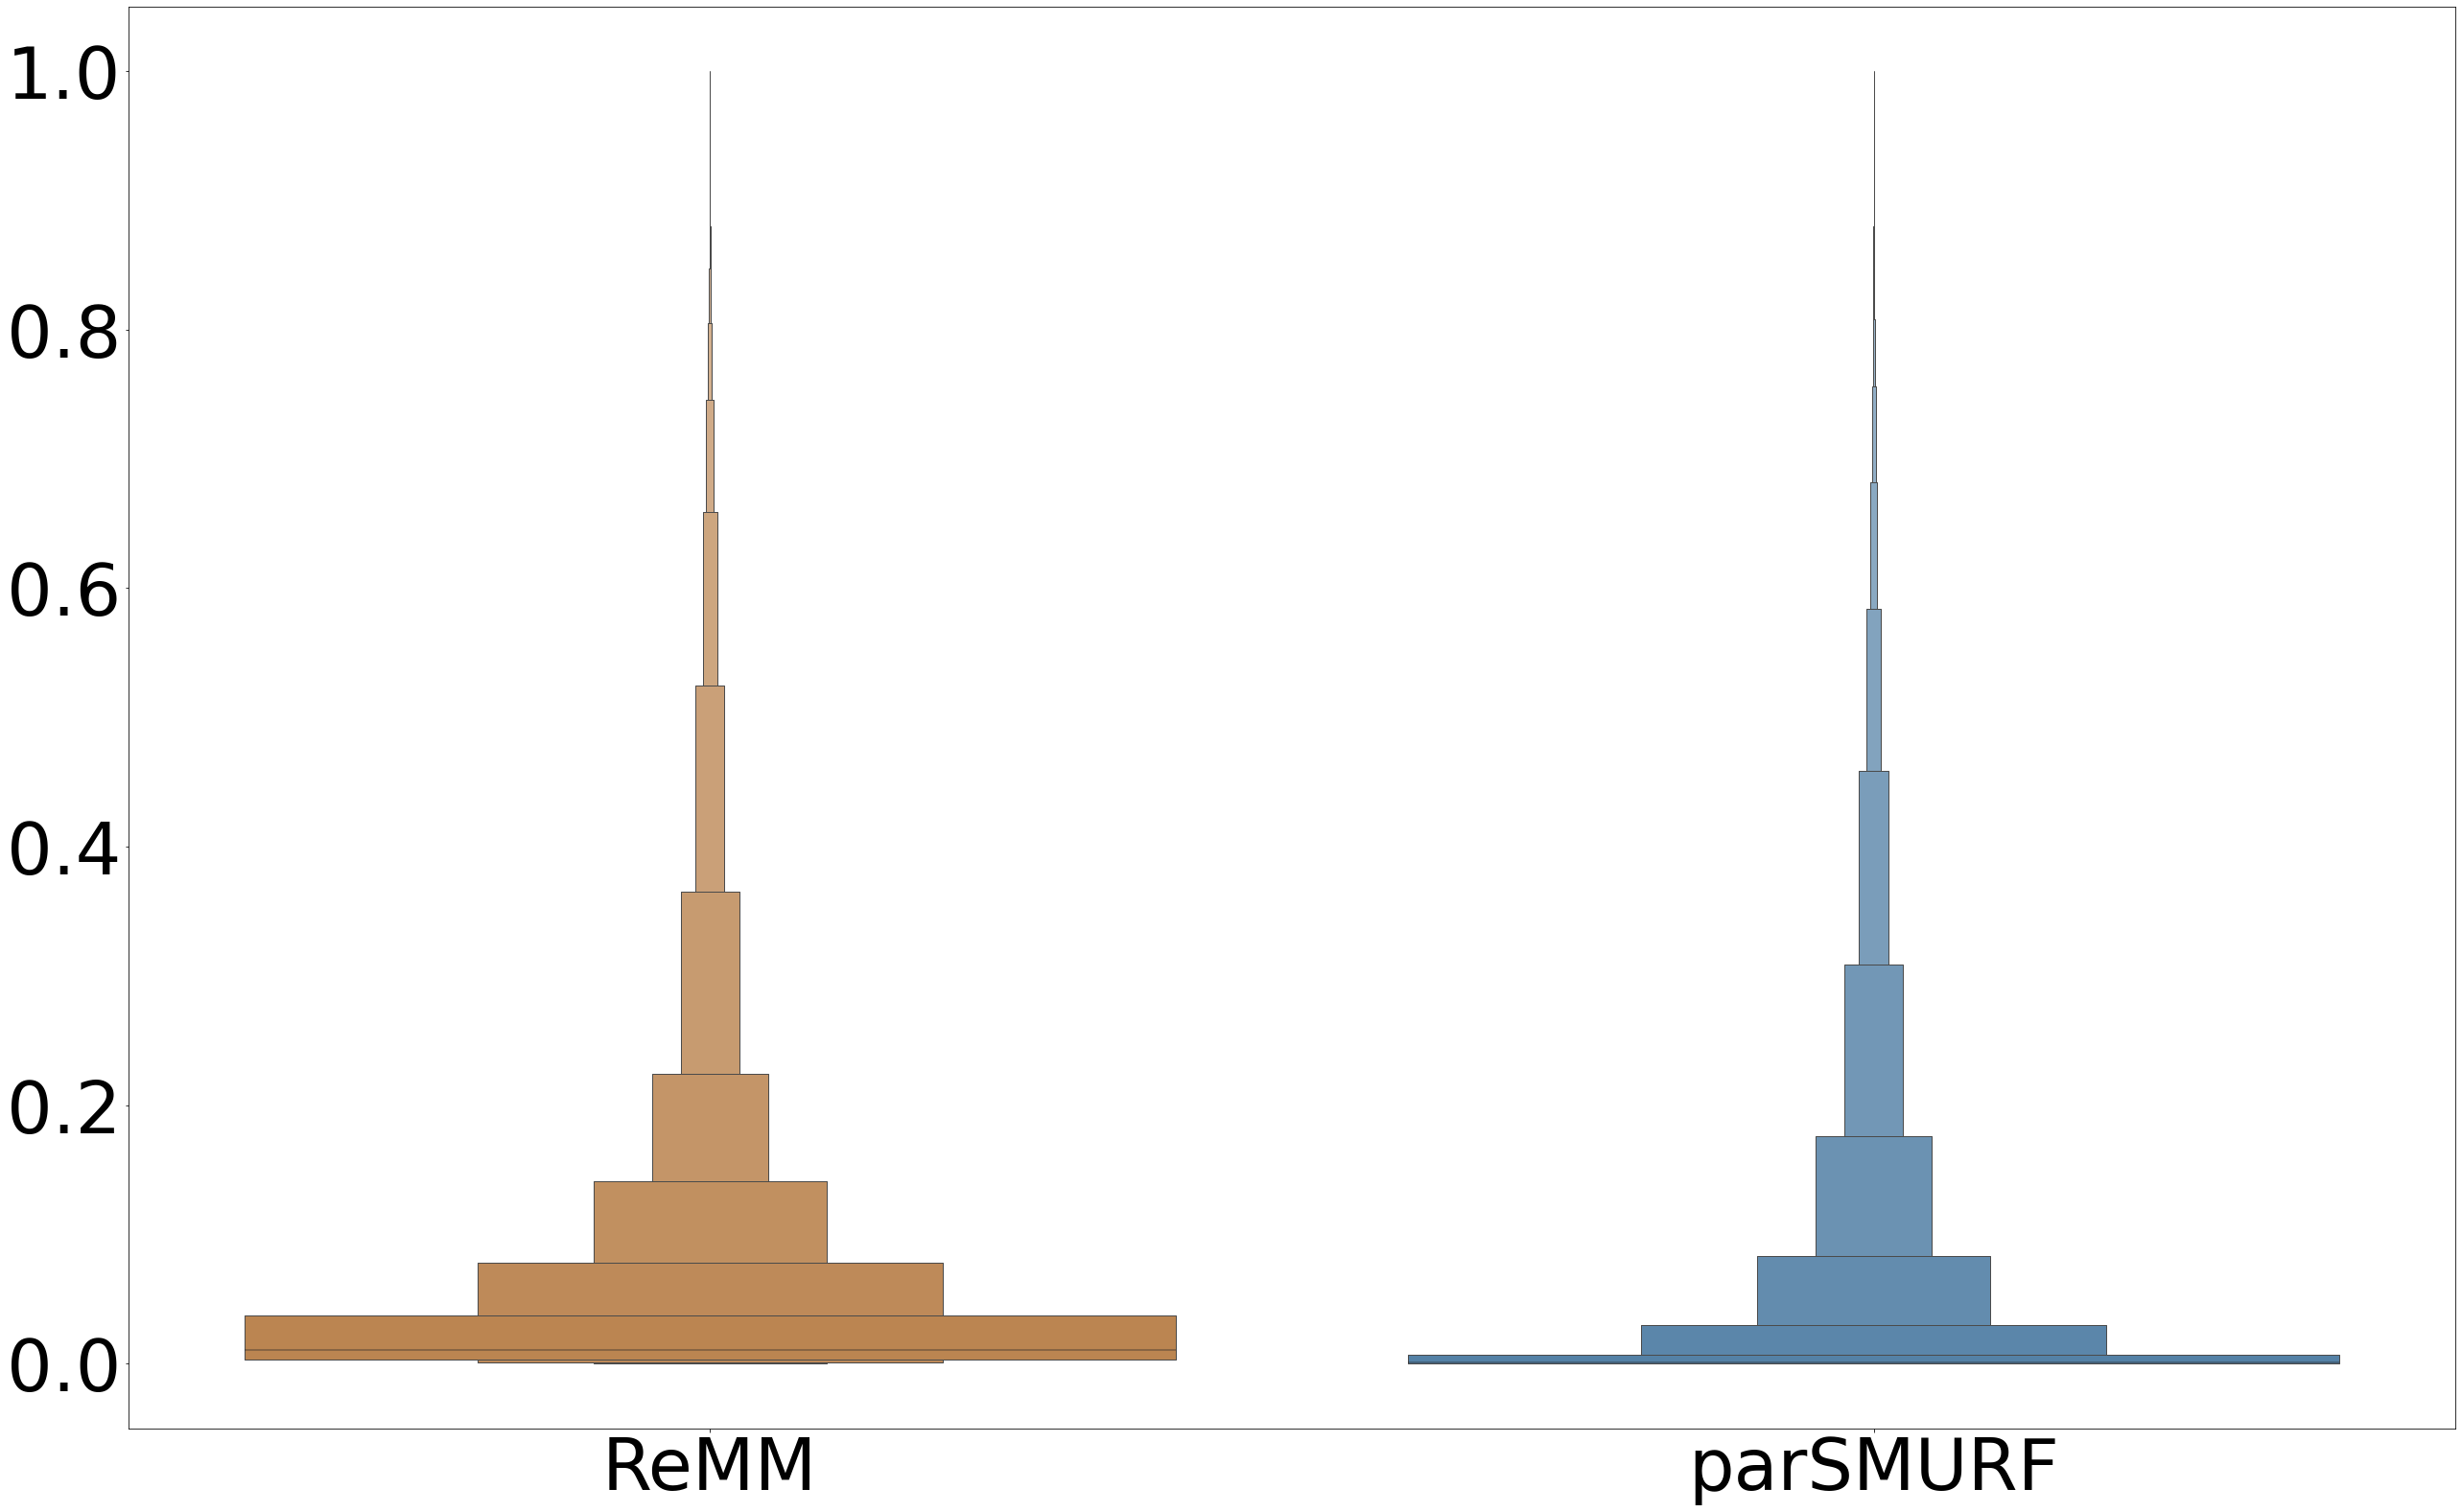

In [159]:
x = 5
stats = ['count','density','frequency']
groups = ['all','pos','true_pos']
intervals = [[0,0.25],[0.25,1],[0,1],[0,0.5],[0.5,1]]
#intervals = [[0,1]]
groups = ['all']
intervals = [[0,0.25],[0.25,1],[0,1]]


for i in intervals:
    a = i[0]
    b = i[1]
    
    _re = f[(f['prob_remm']>=a)&(f['prob_remm']<=b)]
    _ps =f[(f['prob_ps']>=a)&(f['prob_ps']<=b)]
    
    for group in groups:

        name = str(a)+'_'+str(b)+'_'+group
        print(name)

        if group == 'pos':
            re = _re[_re.lab_remm==1]['prob_remm']
            ps = _ps[_ps.lab_ps==1]['prob_ps']
        if group == 'true_pos':
            re = _re[_re.label==1]['prob_remm']
            ps = _ps[_ps.label==1]['prob_ps']
        else:
            re = _re['prob_remm']
            ps = _ps['prob_ps']
        
        fig, ax = plt.subplots(figsize=(7.2*x,4.45*x))  

        sns.boxenplot(data = [re,ps],orient = 'v',showfliers = False)
        ax.set_xticklabels(['ReMM','parSMURF'])
        sns.set_palette(['peru','steelblue']) 
        ax.tick_params(axis='both',  labelsize=15*x)
        ax.tick_params(axis='both', which='minor', labelsize=15*x)
        plt.tight_layout()
        name = name.replace('.','')
        plt.savefig('figures/boxenplot_'+ name+'.png',dpi=30)

        plt.show()


In [ ]:
re = f[(f['prob_remm']>=a)&(f['prob_remm']<b)]['prob_remm']
ps =f[(f['prob_ps']>=a)&(f['prob_ps']<b)]['prob_ps']
re_ = re.round(2).value_counts()/len(re)
ps_ = ps.round(2).value_counts()/len(ps)



#### Histograms

0_0.25_all_log_frequency


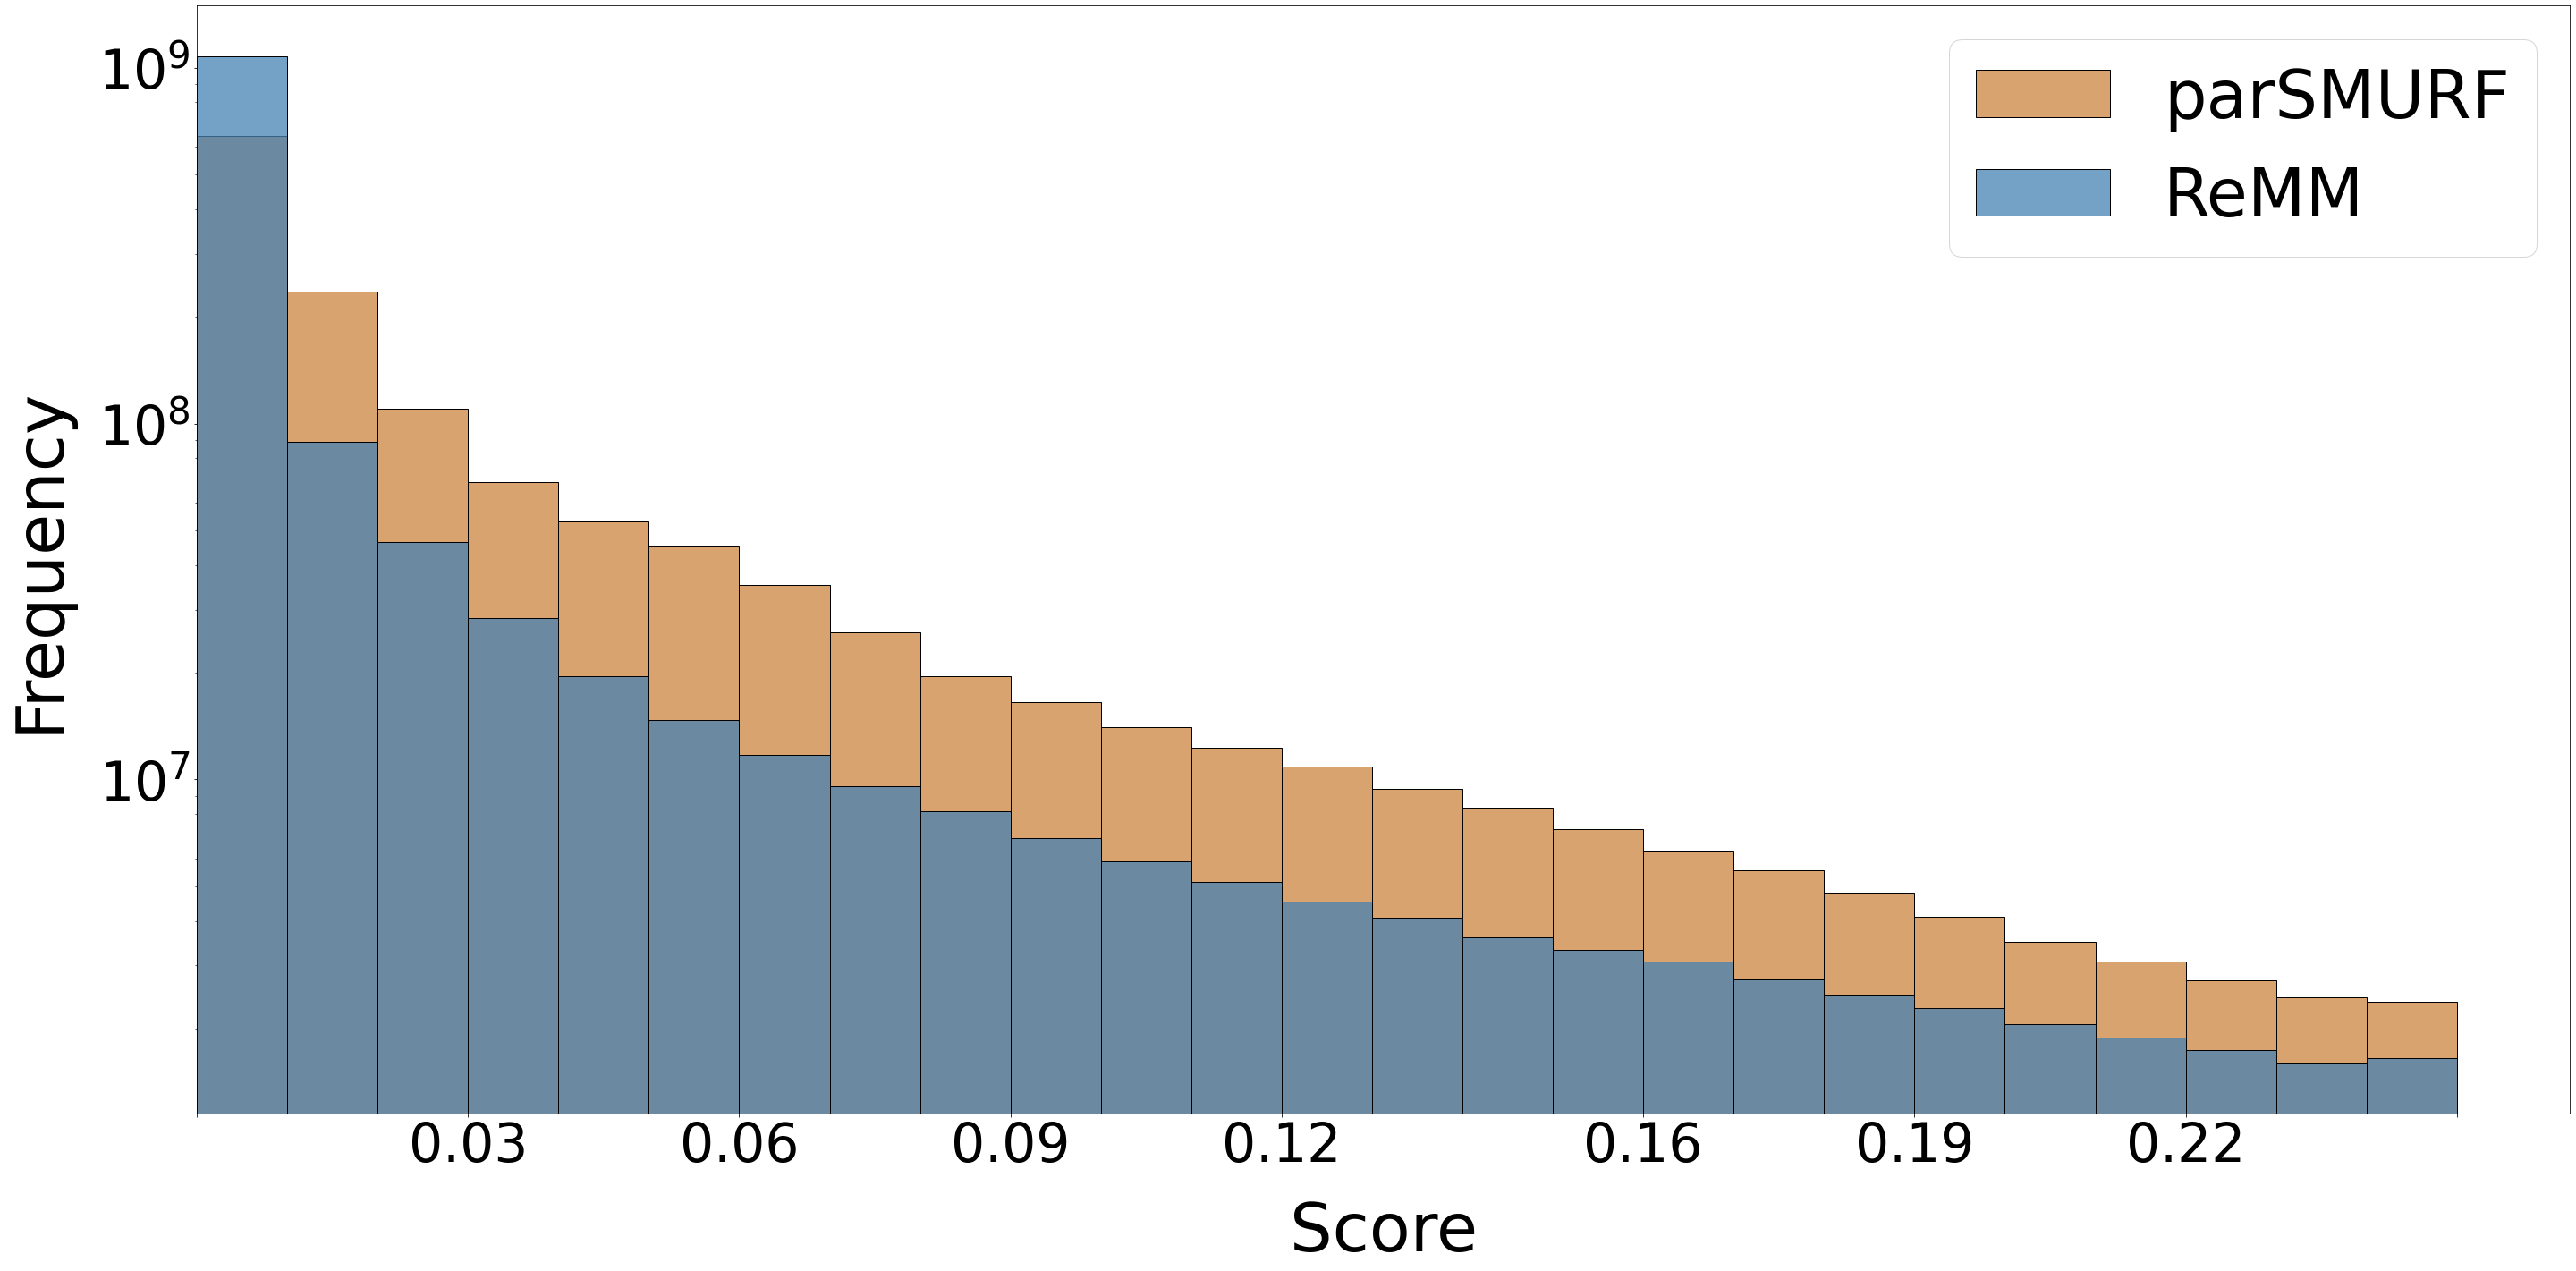

In [32]:
x = 5
stats = ['count','density','frequency']
groups = ['all','pos','true_pos']
intervals = [[0,0.25],[0.25,1],[0,1],[0,0.5],[0.5,1]]
#intervals = [[0,1]]
#groups = ['pos']

#intervals = [[0.5,1]]
stats = ['count','density','frequency']
stats = ['frequency']

scales = ['absolute','log']
scales = ['log']
intervals = [[0,0.25]]
groups = ['all']
for i in intervals:
    a = i[0]
    b = i[1]
    
    _re = f[(f['prob_remm']>=a)&(f['prob_remm']<=b)]
    _ps =f[(f['prob_ps']>=a)&(f['prob_ps']<=b)]
    
    for stat in stats:
        for scale in scales:
            for group in groups:

                name = str(a)+'_'+str(b)+'_'+group+'_'+scale+'_'+stat
                print(name)
                
                if group == 'pos':
                    re = _re[_re.lab_remm==1]['prob_remm']
                    ps = _ps[_ps.lab_ps==1]['prob_ps']
                if group == 'true_pos':
                    re = _re[_re.label==1]['prob_remm']
                    ps = _ps[_ps.label==1]['prob_ps']
                else:
                    re = _re['prob_remm']
                    ps = _ps['prob_ps']

                fig, ax = plt.subplots(figsize=(8*x,4*x))  
                bins = 25
                sns.histplot(re, label = p,color = 'peru',bins = bins, stat = stat)

                sns.histplot(ps, label = r, color = 'steelblue',bins = bins,stat = stat )

                
                ax.tick_params(axis='both', which='both', labelsize=12*x)

                ax.set_xlabel('Score', fontsize = 15*x,labelpad=30)
                ax.set_ylabel(stat.title(),fontsize = 15*x,labelpad=30)

                mn = (min(re.min(),ps.min())).round(2)
                mx = (min(re.max(),ps.max())).round(2)

                ax.set(xlim=mn, xticks=list(np.around(np.linspace(mn,b,9),2)))
                plt.legend(prop={'size': 15*x})
                xticks = ax.xaxis.get_major_ticks()
                xticks[0].label1.set_visible(False)
                xticks[-1].label1.set_visible(False)
                #plt.grid(True, which="major")

                plt.tight_layout()
                #plt.ylim(0, 1.5*10**6)

                if scale == 'log':
                    plt.yscale('log')
                name = name.replace('.','')
                plt.savefig('figures/'+ name+'_.png',dpi=30)

                plt.show()


In [ ]:
re = re.index.drop_duplicates(keep='first')
ps = ps.index.drop_duplicates(keep='first')

re = _re[_re.label==1]['prob_remm']
ps = _ps[_ps.label==1]['prob_ps']
df = pd.DataFrame(ps).join(pd.DataFrame(re), how='left')

#a = len(ps[ps.index.isin(re.index)])
#b = len(re[re.index.isin(ps.index)])

### Venn diagrams

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


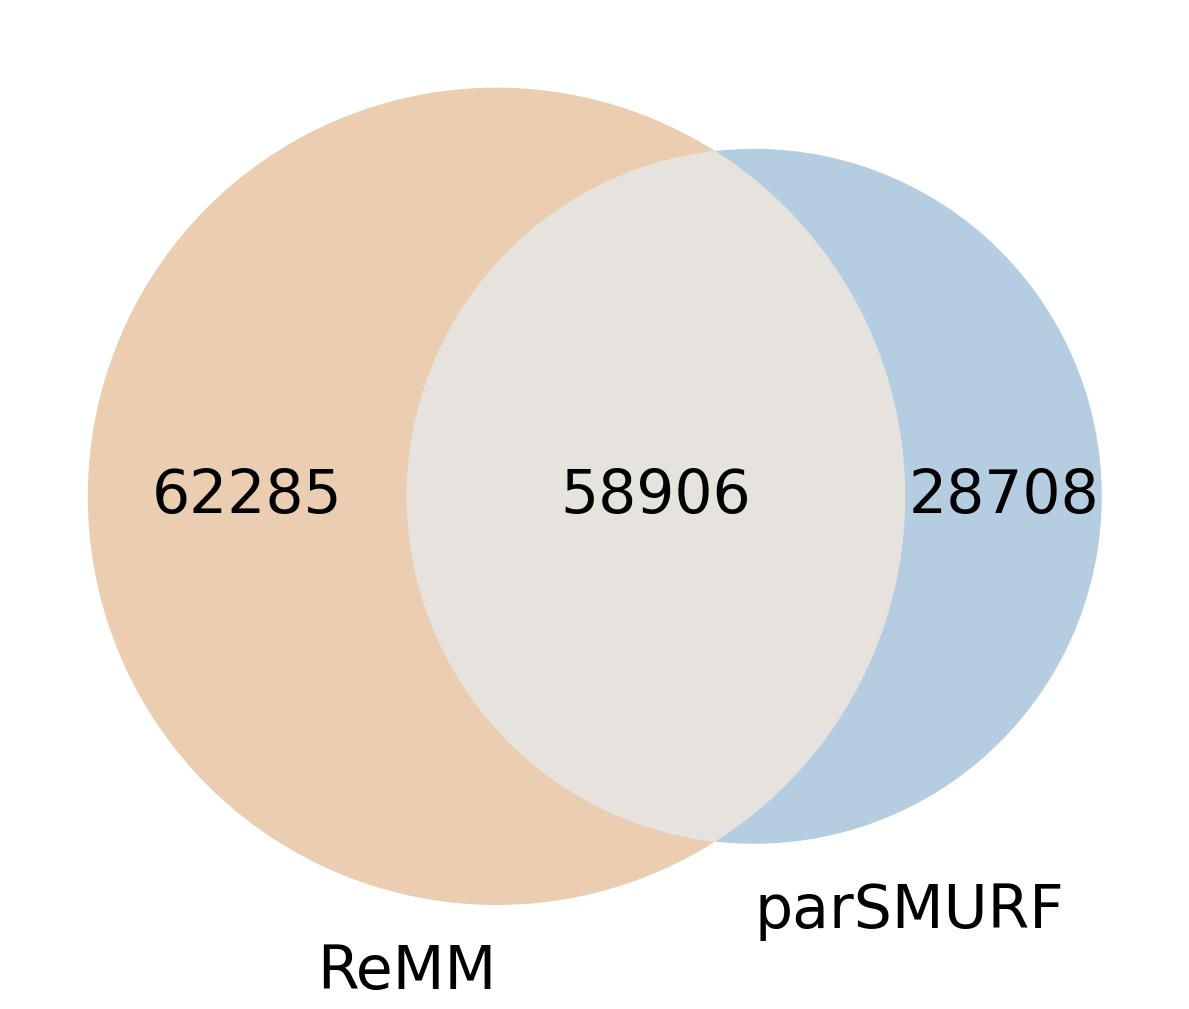

Means of true positive ReMM and PS  0.9249023746701848 0.9278954423592494
Means of all positive ReMM and PS  0.8783004926108374 0.872231527093596
Means of false positive ReMM and PS  0.22414814814814812 0.2430606060606061


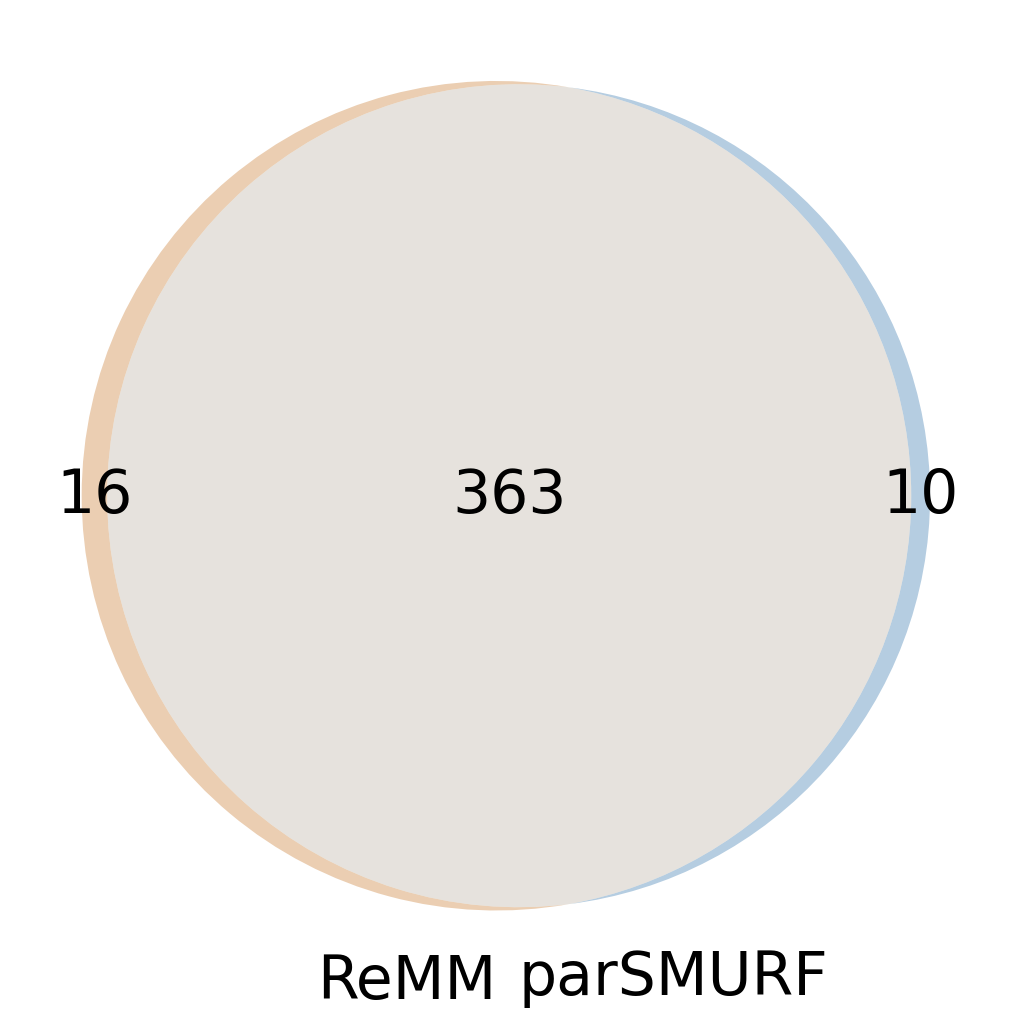

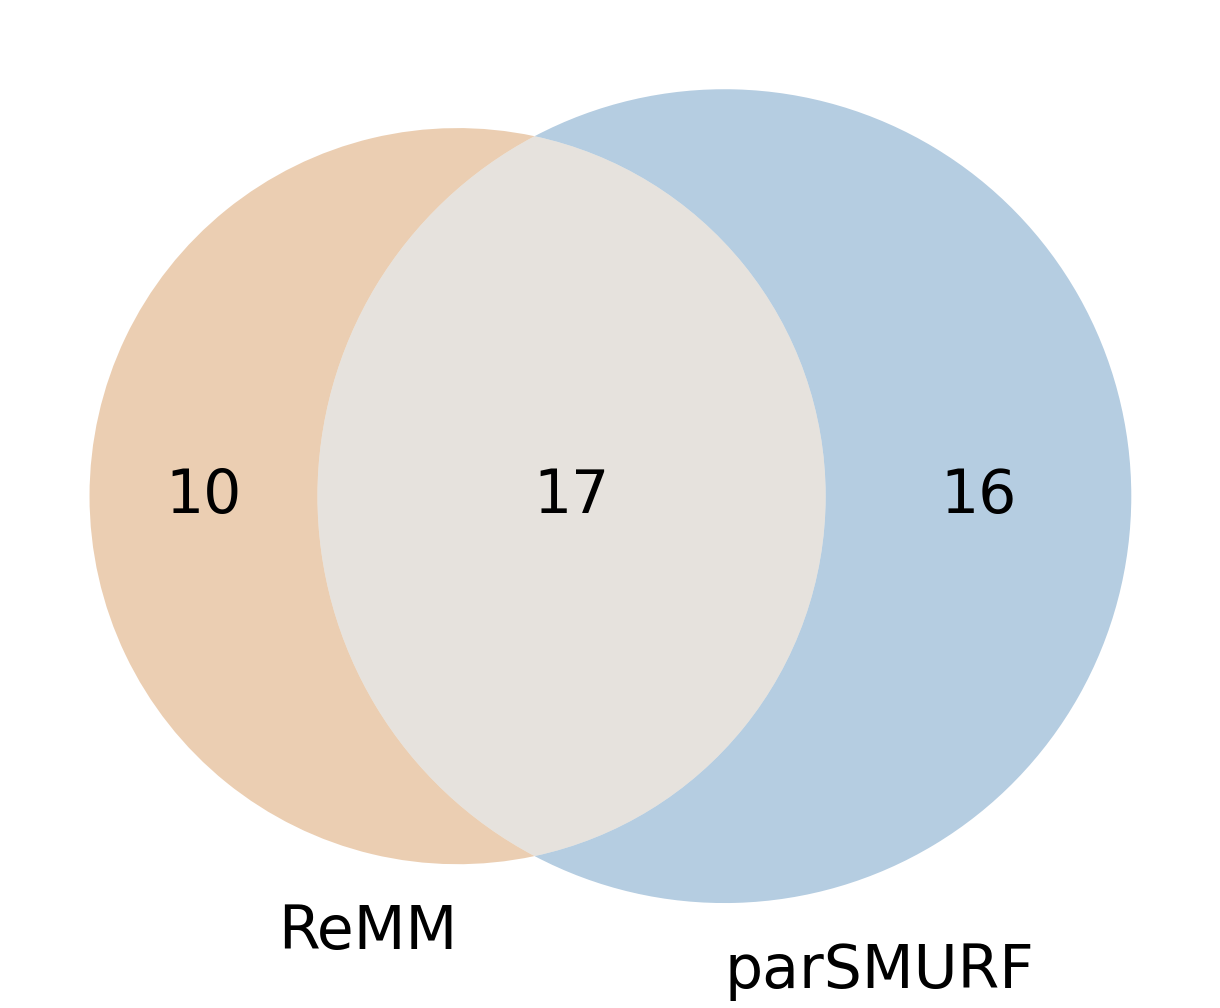

In [108]:
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt


re = f[f['lab_remm']==1].index
ps = f[f['lab_ps']==1].index

a = len(ps[ps.isin(re)])
b = len(re[re.isin(ps)])

def plot_venn(a,b,name):
    x = 2
    fig, ax = plt.subplots(figsize=(16*x,9*x))  
    out = venn2(subsets = (len(re)-a, len(ps)-a,a ), set_labels = ('ReMM', 'parSMURF'), set_colors=('peru','steelblue'))
    for text in out.set_labels:
        text.set_fontsize(60)
    for x in range(len(out.subset_labels)):
        if out.subset_labels[x] is not None:
            out.subset_labels[x].set_fontsize(60)
    plt.savefig('figures/'+name+'.png',dpi=30,bbox_inches='tight')

    plt.show()

plot_venn(a,b,'all_pos')

ff = f[f['label']==1]

re = ff[ff['lab_remm']==1].index
ps = ff[ff['lab_ps']==1].index

aa = f[(f['label']==1)]['prob_remm'].mean()
bb = f[(f['label']==1)]['prob_ps'].mean()


print('Means of true positive ReMM and PS ',ff[ff['lab_remm']==1]['prob_remm'].mean(),ff[ff['lab_ps']==1]['prob_ps'].mean())
print('Means of all positive ReMM and PS ',aa,bb)

aa = ff[(ff['lab_remm']==0)]['prob_remm'].mean()
bb = ff[(ff['lab_ps']==0)]['prob_ps'].mean()

print('Means of false positive ReMM and PS ',aa,bb)


a = len(ps[ps.isin(re)])
b = len(re[re.isin(ps)])

plot_venn(a,b,'pos')

ff = f[f['label']==1]

re = ff[ff['lab_remm']==0].index
ps = ff[ff['lab_ps']==0].index

a = len(ps[ps.isin(re)])
b = len(re[re.isin(ps)])

plot_venn(a,b,'false_pos')




